# Noisy Bilocal Network Optimization

In this notebook, we optimize quantum non-bilocality in the presence of noise.
The bilocal network consists of three measurement nodes that connected in a line by two preparation nodes.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

import qnetvo as qnet

In [14]:
prep_nodes = [
    qnet.PrepareNode(1, [0,1], qml.ArbitraryStatePreparation, 6),
    qnet.PrepareNode(1, [2,3], qml.ArbitraryStatePreparation, 6),
]
meas_nodes = [
    qnet.MeasureNode(2, 2, [0], qml.ArbitraryUnitary, 3),
    qnet.MeasureNode(2, 2, [1,2], qml.ArbitraryUnitary, 15),
    qnet.MeasureNode(2, 2, [3], qml.ArbitraryUnitary, 3),
]

def pure_qubit_noise_nodes(fn, noise_param):
    return [qnet.NoiseNode([i, i+4], lambda settings, wires: fn(noise_param, wires=wires)) for i in range(4)]

def mixed_qubit_noise_nodes(fn, noise_params):
    return [qnet.NoiseNode([i], lambda settings, wires: fn(*noise_params[i], wires=wires[0])) for i in range(4)]

## Optimizing Bilocal Chains with Uniform Qubit Channel Noise

In this section, we optimize non-bilocality for the Bilocal Chain with different qubit noise channels.
The same noise is applied to each qubit independently. 

## Bilocal Uniform Qubit Depolarizing Noise

We use the PennyLane `"default.mixed"` simulator to apply a depolarizing channel to each qubit.
This simulator uses density matrix operations and is significantly slower than the `"default.qubit"` device which uses a state vector simulation.

In [7]:
%%time

depolarized_bilocal_opt_dicts = []

for gamma in np.arange(0,0.121,0.03):
    print("gamma : ", gamma)
    noise_nodes = mixed_qubit_noise_nodes(qml.DepolarizingChannel, [[gamma]]*4)
    depolarized_bilocal_ansatz = qnet.NetworkAnsatz(prep_nodes, meas_nodes, noise_nodes)
    depolarized_bilocal_cost = qnet.nlocal_chain_cost_22(depolarized_bilocal_ansatz)
    
    np.random.seed(1)
    depolarized_bilocal_settings = depolarized_bilocal_ansatz.rand_scenario_settings()

    depolarized_bilocal_opt_dict = qnet.gradient_descent(
        depolarized_bilocal_cost,
        depolarized_bilocal_settings,
        num_steps=15,
        step_size=0.8,
        sample_width = 3
    )
    
    depolarized_bilocal_opt_dicts.append(depolarized_bilocal_opt_dict)
    
    print("max score : ", depolarized_bilocal_opt_dict["opt_score"])

gamma :  0.0
iteration :  0 , score :  0.6077670691442973


/Users/brian/opt/anaconda3/envs/qnetvo-dev/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


elapsed time :  8.606683015823364
iteration :  3 , score :  1.250961928317059
elapsed time :  8.412764072418213
iteration :  6 , score :  1.3566424077495955
elapsed time :  8.746578931808472
iteration :  9 , score :  1.392456650164628
elapsed time :  9.314065933227539
iteration :  12 , score :  1.4042126164387456
elapsed time :  8.893157958984375
max score :  1.4088784069458977
gamma :  0.03
iteration :  0 , score :  0.5573187223446399
elapsed time :  9.52016282081604
iteration :  3 , score :  1.1392775225170038
elapsed time :  9.533854007720947
iteration :  6 , score :  1.2397771411077403
elapsed time :  9.669780969619751
iteration :  9 , score :  1.2779716467380782
elapsed time :  9.331990718841553
iteration :  12 , score :  1.2915645789022454
elapsed time :  9.503400087356567
max score :  1.2970107726045588
gamma :  0.06
iteration :  0 , score :  0.5090276770267235
elapsed time :  9.092700719833374
iteration :  3 , score :  1.0332497219659338
elapsed time :  9.320312261581421
iterat

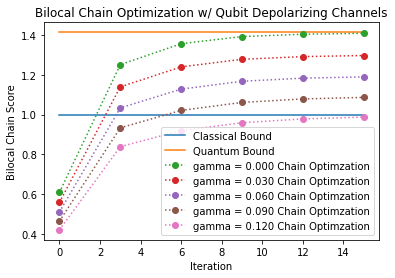

In [8]:
samples = depolarized_bilocal_opt_dicts[0]["samples"]

plt.plot(samples, [1]*len(samples), label = "Classical Bound")
plt.plot(samples, [2/np.sqrt(2)]*len(samples), label = "Quantum Bound")

id = 0
gammas = np.arange(0,0.121,0.03)
for opt_dict in depolarized_bilocal_opt_dicts:
    plt.plot(samples, opt_dict["scores"], "o:", label = r"gamma = {:.3f} Chain Optimzation".format(gammas[id]))
    id += 1

plt.title(r"Bilocal Chain Optimization w/ Qubit Depolarizing Channels")
plt.xlabel("Iteration")
plt.ylabel(r"Bilocal Chain Score")
plt.legend()
plt.show()

## Bilocal Uniform Amplitude Damping Optimization

Amplitude damping noise can be implemented on a quantum circuit with one ancilla.
The circuit implementation is compatible with the `"default.qubit"` simulator in PennyLane
significantlly improving optimization performance.

In [19]:
%%time

ampdamp_bilocal_opt_dicts = []

for gamma in np.arange(0,0.241,0.06):
    print("gamma : ", gamma)
    ampdamp_nodes = pure_qubit_noise_nodes(qnet.pure_amplitude_damping, [gamma])
    ampdamp_bilocal_ansatz = qnet.NetworkAnsatz(
        prep_nodes,
        meas_nodes,
        ampdamp_nodes,
        dev_kwargs={"name" : "default.qubit"} # override the default.mixed simulator
    )
    ampdamp_bilocal_cost = qnet.nlocal_chain_cost_22(ampdamp_bilocal_ansatz)
    
    np.random.seed(1)
    ampdamp_bilocal_settings = ampdamp_bilocal_ansatz.rand_scenario_settings()

    ampdamp_bilocal_opt_dict = qnet.gradient_descent(
        ampdamp_bilocal_cost,
        ampdamp_bilocal_settings,
        num_steps=15,
        step_size=0.8,
        sample_width = 3
    )
    
    ampdamp_bilocal_opt_dicts.append(ampdamp_bilocal_opt_dict)
    
    print("max score : ", ampdamp_bilocal_opt_dict["opt_score"])

gamma :  0.0
iteration :  0 , score :  0.6077670691442971
elapsed time :  0.2654380798339844
iteration :  3 , score :  1.2509619283170594
elapsed time :  0.3444979190826416
iteration :  6 , score :  1.3566424077495953
elapsed time :  0.2957630157470703
iteration :  9 , score :  1.3924566501646276
elapsed time :  0.34701108932495117
iteration :  12 , score :  1.4042126164387465
elapsed time :  0.286240816116333
max score :  1.4088784069458984
gamma :  0.06
iteration :  0 , score :  0.5902731894624239
elapsed time :  0.32714176177978516
iteration :  3 , score :  1.1615437308324905
elapsed time :  0.361828088760376
iteration :  6 , score :  1.249845342947932
elapsed time :  0.2932398319244385
iteration :  9 , score :  1.2837543086866505
elapsed time :  0.34834718704223633
iteration :  12 , score :  1.2967614664455707
elapsed time :  0.29910874366760254
max score :  1.302262403831543
gamma :  0.12
iteration :  0 , score :  0.5710885580963803
elapsed time :  0.3481011390686035
iteration :  

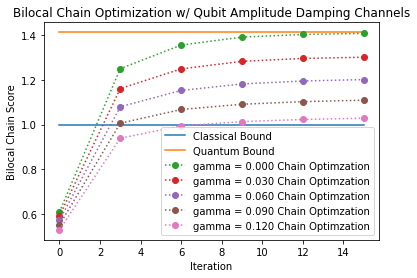

In [16]:
samples = ampdamp_bilocal_opt_dicts[0]["samples"]

plt.plot(samples, [1]*len(samples), label = "Classical Bound")
plt.plot(samples, [2/np.sqrt(2)]*len(samples), label = "Quantum Bound")

id = 0
gammas = np.arange(0,0.121,0.03)
for opt_dict in ampdamp_bilocal_opt_dicts:
    plt.plot(samples, opt_dict["scores"], "o:", label = r"gamma = {:.3f} Chain Optimzation".format(gammas[id]))
    id += 1

plt.title(r"Bilocal Chain Optimization w/ Qubit Amplitude Damping Channels")
plt.xlabel("Iteration")
plt.ylabel(r"Bilocal Chain Score")
plt.legend()
plt.show()

## Bilocal Uniform Phase Damping Noise Optimization

Qubit Phase damping noise can also be implemented using a single ancillary qubit.
Hence we use the `"default.qubit"` simulator to optimize the network.

In [17]:
%%time

phase_damp_bilocal_opt_dicts = []

for gamma in np.arange(0,0.241,0.06):
    print("gamma : ", gamma)
    phase_damp_nodes = pure_qubit_noise_nodes(qnet.pure_phase_damping, [gamma])
    phase_damp_bilocal_ansatz = qnet.NetworkAnsatz(
        prep_nodes,
        meas_nodes,
        phase_damp_nodes,
        dev_kwargs={"name" : "default.qubit"} # override the default.mixed simulator
    )
    phase_damp_bilocal_cost = qnet.nlocal_chain_cost_22(phase_damp_bilocal_ansatz)
    
    np.random.seed(1)
    phase_damp_bilocal_settings = phase_damp_bilocal_ansatz.rand_scenario_settings()

    phase_damp_bilocal_opt_dict = qnet.gradient_descent(
        phase_damp_bilocal_cost,
        phase_damp_bilocal_settings,
        num_steps=15,
        step_size=0.8,
        sample_width = 3
    )
    
    phase_damp_bilocal_opt_dicts.append(phase_damp_bilocal_opt_dict)
    
    print("max score : ", phase_damp_bilocal_opt_dict["opt_score"])

gamma :  0.0
iteration :  0 , score :  0.6077670691442971
elapsed time :  0.33769822120666504
iteration :  3 , score :  1.2509619283170594
elapsed time :  0.3555018901824951
iteration :  6 , score :  1.3566424077495953
elapsed time :  0.29065513610839844
iteration :  9 , score :  1.3924566501646276
elapsed time :  0.28005385398864746
iteration :  12 , score :  1.4042126164387465
elapsed time :  0.36522889137268066
max score :  1.4088784069458984
gamma :  0.06
iteration :  0 , score :  0.5778186647702314
elapsed time :  0.25380802154541016
iteration :  3 , score :  1.1888465206890961
elapsed time :  0.27851414680480957
iteration :  6 , score :  1.2933488104171666
elapsed time :  0.34722399711608887
iteration :  9 , score :  1.3300923679569383
elapsed time :  0.272752046585083
iteration :  12 , score :  1.3426007600916774
elapsed time :  0.31756591796875
max score :  1.347669764656318
gamma :  0.12
iteration :  0 , score :  0.5475327254431642
elapsed time :  0.3462331295013428
iteration 

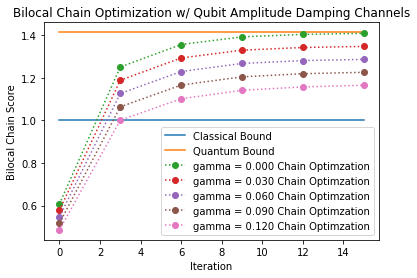

In [18]:
samples = phase_damp_bilocal_opt_dicts[0]["samples"]

plt.plot(samples, [1]*len(samples), label = "Classical Bound")
plt.plot(samples, [2/np.sqrt(2)]*len(samples), label = "Quantum Bound")

id = 0
gammas = np.arange(0,0.121,0.03)
for opt_dict in phase_damp_bilocal_opt_dicts:
    plt.plot(samples, opt_dict["scores"], "o:", label = r"gamma = {:.3f} Chain Optimzation".format(gammas[id]))
    id += 1

plt.title(r"Bilocal Chain Optimization w/ Qubit Amplitude Damping Channels")
plt.xlabel("Iteration")
plt.ylabel(r"Bilocal Chain Score")
plt.legend()
plt.show()